In [1]:
import os
import numpy as np

from utils import plot_1d_statistic_over_time

In [2]:
# load trajectories
test_dir = "../data/test/"
trajectory_paths = [os.path.join(root, file) for root, _, files in os.walk(test_dir) for file in files if file.endswith(".npz")]
trajectories = [np.load(trajectory_path) for trajectory_path in trajectory_paths]

In [3]:
# Descriptive statistics
from collections import Counter

values = []

for traj in trajectories:
    x_t, _, _ = traj.values()
    values.append(x_t.shape[0])

for traj_len, occ in dict(sorted(Counter(values).items())).items():
    print("Trajectories with length", traj_len, "occur", occ, "times.")

print("Total number of trajectories", len(trajectories))

Trajectories with length 42 occur 19 times.
Trajectories with length 92 occur 20 times.
Trajectories with length 492 occur 17 times.
Trajectories with length 992 occur 21 times.
Total number of trajectories 77


In [4]:
# configs
INDEX_MAPPING = {
    "output": {
        "indices": [0, 1, 2, 3, 4, 5, 6],
        "names": []
    },
    "forcing": {
        "indices": [7, 8],
        "names": []
    },
    "pdes": {
        "indices": [9, 10, 11, 12],
        "names": ["neutral_energy", "mass", "b_field", "sintheta_cc"]
    }
}
OMEGA = 20

In [5]:
# load model
from models import Forward, Prior, Posterior, Decoder

forward = Forward()
forward.load_weights("../weights/forward_t.weights.h5")
prior = Prior()
prior.load_weights("../weights/prior.weights.h5")
posterior = Posterior()
posterior.load_weights("../weights/posterior.weights.h5")
decoder = Decoder()
decoder.load_weights("../weights/decoder.weights.h5")

### Attempt with code from utils.py

In [7]:
import keras

def generate(true_trajectory, forward_t, prior, decoder):
    """
    Generate a trajectory using the starting point and forcing variables provided.
    Args:
        true_trajectory: list of tensors of shape [omega, 500, 8]
    """
    # Generate trajectory by iteration
    gen_trajectory = [true_trajectory[0][...,:-2]]
    for i in range(len(true_trajectory)):
        # Concatenate forcing variables
        x_t_hat = keras.ops.concatenate([
            gen_trajectory[i], 
            true_trajectory[i][...,-2:]
        ], axis=-1)
        # Generate
        h_t = forward_t(keras.ops.expand_dims(x_t_hat, axis=0))
        z, *_ = prior(h_t)
        x_tplus1_hat = decoder(z, h_t)[0]
        # Save
        gen_trajectory.append(x_tplus1_hat)
    return gen_trajectory

In [8]:
import torch

# take sample test trajectory
trajectory = trajectories[0]

# extract desired elements
X, F, PDE = torch.tensor(trajectory["output"]), torch.tensor(trajectory["forcing"]), torch.tensor(trajectory["pde_vars"])

# forward through the model
input_data = torch.cat([X, F], dim=-1).unsqueeze(0)
X_hat = generate(input_data, forward, prior, decoder)

/home/robert/venv/lib/python3.12/site-packages/keras/src/backend/common/backend_utils.py:91: UserWarning: You might experience inconsistencies across backends when calling conv transpose with kernel_size=3, stride=2, dilation_rate=1, padding=same, output_padding=1.
  warnings.warn(


(42, 500, 6)
(42, 500)


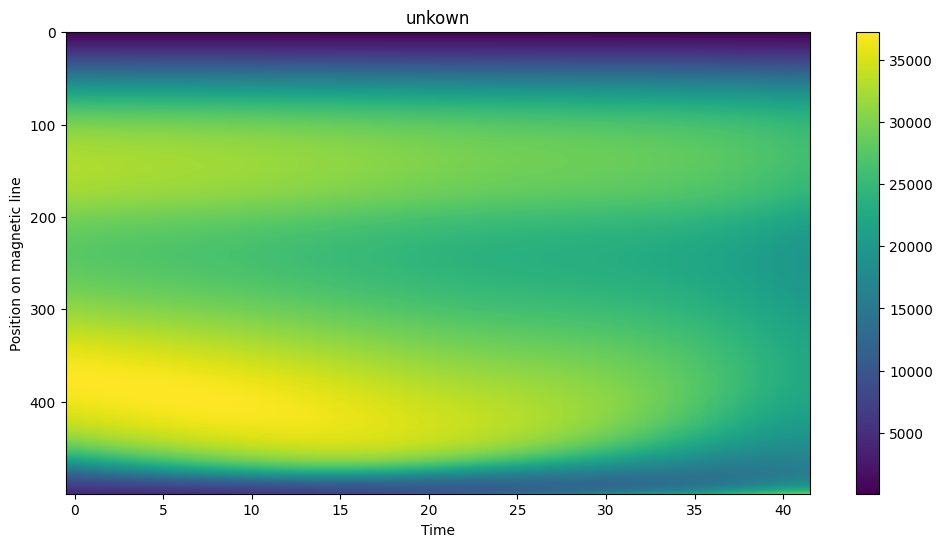

(42, 500, 6)
(42, 500)


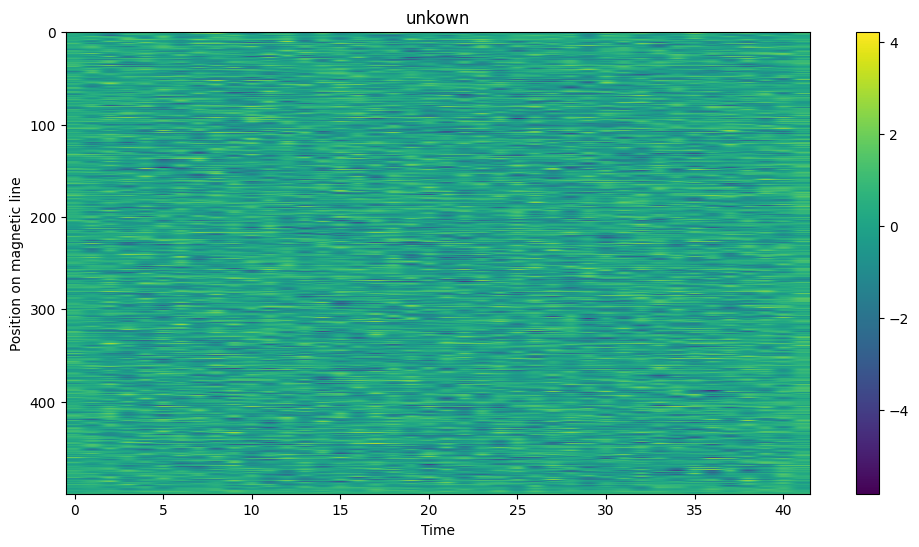

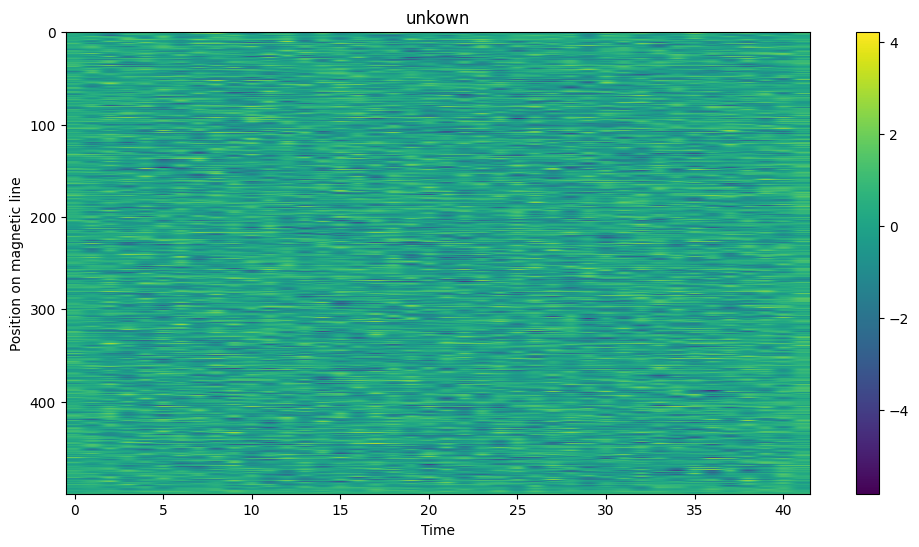

In [9]:
plot_1d_statistic_over_time(X_hat[0].detach().numpy(), 1, "unkown")
plot_1d_statistic_over_time(X_hat[1].detach().numpy(), 1, "unkown")

### Try scaling

In [10]:
import torch

# take sample test trajectory
trajectory = trajectories[0]

# extract desired elements
X, F, PDE = torch.tensor(trajectory["output"]), torch.tensor(trajectory["forcing"]), torch.tensor(trajectory["pde_vars"])

# forward through the model
input_data = torch.cat([X, F], dim=-1).unsqueeze(0)
mean, std = torch.std_mean(torch.cat([X, F], dim=-1))
input_data = (input_data - mean) / std
X_hat = generate(input_data, forward, prior, decoder)

(42, 500, 6)
(42, 500)


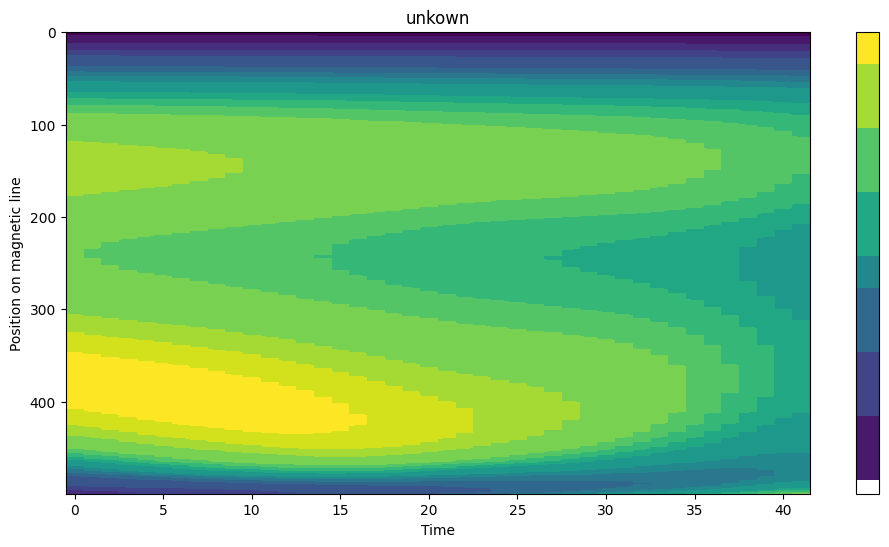

(42, 500, 6)
(42, 500)


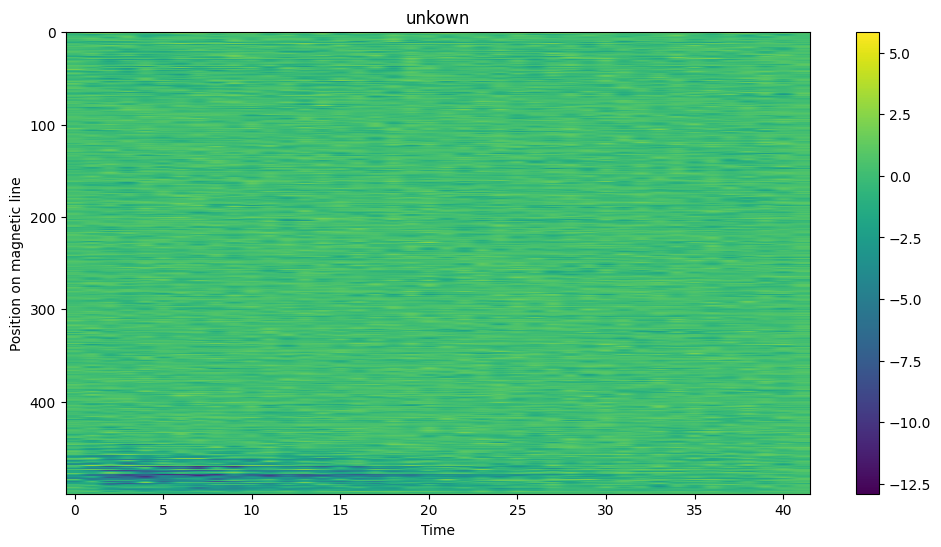

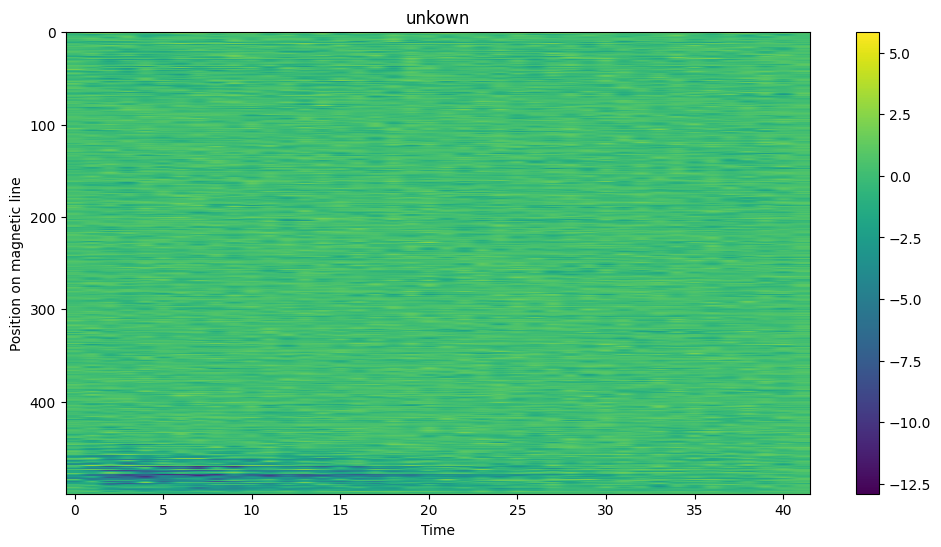

In [11]:
plot_1d_statistic_over_time(X_hat[0].detach().numpy(), 1, "unkown")
plot_1d_statistic_over_time(X_hat[1].detach().numpy(), 1, "unkown")

## Attempt with custom code with scaling

In [16]:
def forward_pass(x_t):
    h_t = forward(x_t.unsqueeze(0))
    z = prior(h_t)[0]
    return decoder(z, h_t).squeeze(0)

In [19]:
import torch

# take sample test trajectory
trajectory = trajectories[0]

# extract desired elements
X, F, PDE = torch.tensor(trajectory["output"]), torch.tensor(trajectory["forcing"]), torch.tensor(trajectory["pde_vars"])

# scale
mean, std = torch.std_mean(torch.cat([X, F], dim=-1))
X_scaled = (X - mean) / std
F_scaled = (F - mean) / std

# initialize with start of the trajectory
X_hat = X_scaled[:OMEGA, ...].clone()

# number of time blocks to predict
iterations = X_scaled.shape[0] // OMEGA

# predict next time blocks
for i in range(1, iterations):

    F_index_start = i * OMEGA
    F_index_end = (i+1) * OMEGA

    input_data = torch.cat([X_hat[-OMEGA:, ...], F_scaled[F_index_start:F_index_end, ...]], axis=-1)    
    pred = forward_pass(input_data)

    X_hat = torch.cat([X_hat, pred], axis=0)

X_hat = X_hat * std + mean

### Custom code without scaling

In [14]:
import torch

# take sample test trajectory
trajectory = trajectories[0]

# extract desired elements
X, F, PDE = torch.tensor(trajectory["output"]), torch.tensor(trajectory["forcing"]), torch.tensor(trajectory["pde_vars"])

# initialize with start of the trajectory
X_hat = X[:OMEGA, ...].clone()

# number of time blocks to predict
iterations = X.shape[0] // OMEGA

# predict next time blocks
for i in range(1, iterations):

    F_index_start = i * OMEGA
    F_index_end = (i+1) * OMEGA

    input_data = torch.cat([X_hat[-OMEGA:, ...], F[F_index_start:F_index_end, ...]], axis=-1)    
    pred = forward_pass(input_data)

    X_hat = torch.cat([X_hat, pred], axis=0)

torch.Size([42, 500, 6])
torch.Size([42, 500])


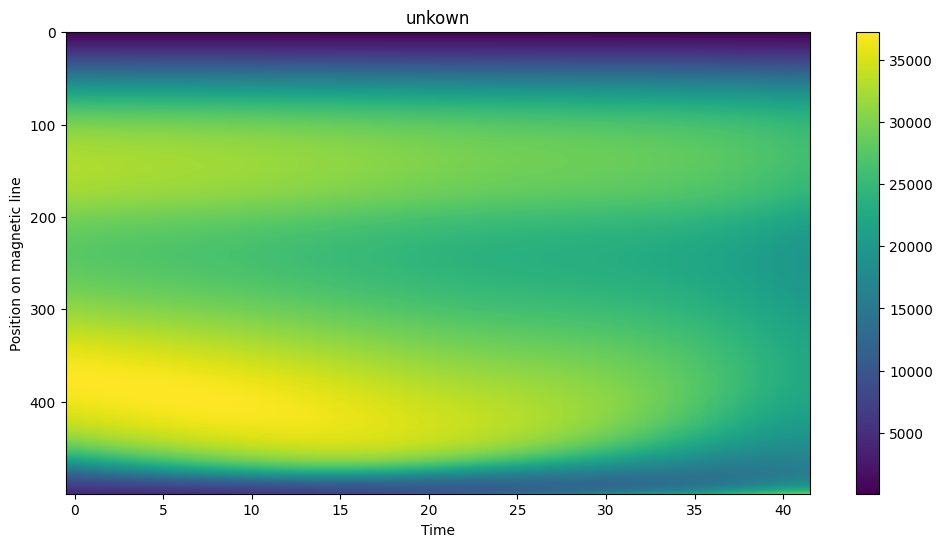

(40, 500, 6)
(40, 500)


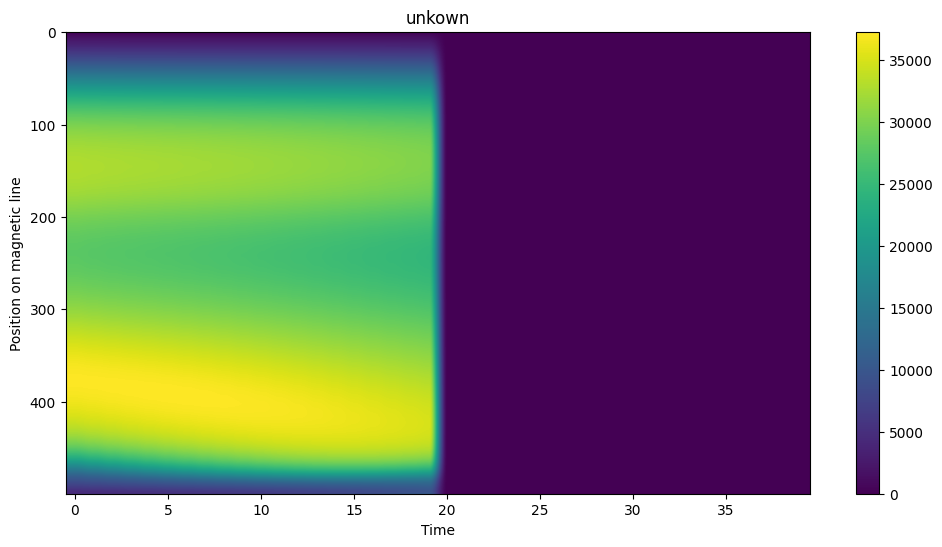

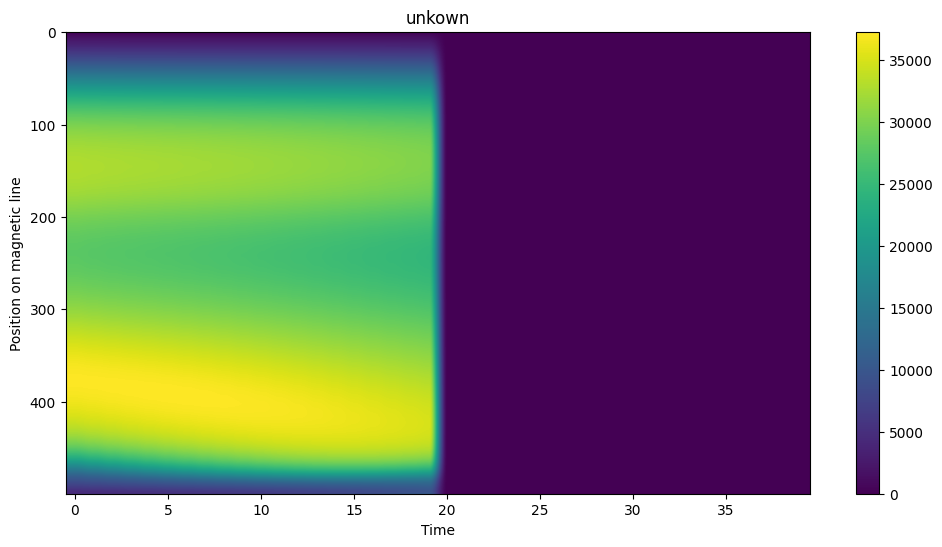

In [15]:
index = 1

plot_1d_statistic_over_time(X, index, "unkown")
plot_1d_statistic_over_time(X_hat.detach().numpy(), index, "unkown")